In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import csd
from data_preprocessing import preprocess
import seaborn as sns


dataframe = preprocess()


def cross_spectral_matrix(patient_id, wave_option='power_beta'):
    # Filter data for the selected patient
    patient_data = dataframe[dataframe['id'] == patient_id]

    # Create an empty list to hold the power data for each region (channel)
    power_data = []

    sampling_freq = 128

    # Loop through the regions (channels) and extract power data
    for region in patient_data['region'].unique():
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        
        # Append the power data (list) for this region to the list
        power_data.append(region_data[wave_option].values[0])  # Assuming 'power' is a list

    # Convert the list of power data (regions x time points) into a DataFrame
    power_df = pd.DataFrame(power_data).transpose()  # 16 channels x 240 time points

    # Check for NaN values and fill or drop them
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  # Fill NaN with 0 (you can change this to another method)

    channels = power_df.columns
    csd_matrix = np.zeros((len(channels), len(channels)), dtype=complex)

    #Compute CSD Matrix
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            # Compute CSD between two channels
            freqs, csd_values = csd(power_df[ch1], power_df[ch2], fs=sampling_freq, nperseg=256)
            
            # Take the average value of the CSD (optional: could store full spectrum instead)
            csd_matrix[i, j] = np.mean(csd_values)

    #Normalize CSD Matrix
    for i in range(len(channels)):
        for j in range(len(channels)):
            if i != j:
                csd_matrix[i, j] = csd_matrix[i, j] / np.sqrt(csd_matrix[i, i] * csd_matrix[j, j])
    
    np.fill_diagonal(csd_matrix, 1) #I explicitly set the diagonals to 1, because when computing the average across patients, i take the magnitude of the average csd matrix and it messes it up
    # Return the CSD matrix
    return csd_matrix, freqs
    

def average_csd(patient_ids, wave_option='power_beta'):
    csd_sums = None
    count = 0

    # Loop through each patient and calculate their CSD matrix
    for patient_id in patient_ids:
        csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option)  # Call your CSD function

    # Add the current CSD matrix to the cumulative sum
        if csd_sums is None:
            csd_sums = csd_matrix
        else:
            csd_sums += csd_matrix

        count += 1

    # Calculate the average CSD matrix
    average_csd_matrix = np.abs(csd_sums / count) #Manitude of the complex values

   # average_csd_df = pd.DataFrame(average_csd_matrix)

    return average_csd_matrix




In [2]:
df = dataframe

In [3]:

def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta'):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy = average_csd(healthy_patients, wave_option=wave_option)
    avg_corr_schizo = average_csd(schizo_patients, wave_option=wave_option)
    corr_difference = avg_corr_healthy - avg_corr_schizo

    # Get the regions (they should be consistent across all patients)
    regions = avg_corr_healthy.columns.tolist()  # Get region names from the columns of the correlation matrix

    # Plot for healthy patients
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_corr_healthy, annot=True, cmap='Oranges', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title(f"Average Correlation Matrix for Healthy Patients ({wave_option.capitalize()})")
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()

    # Plot for schizophrenic patients
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_corr_schizo, annot=True, cmap='Oranges', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title(f"Average Correlation Matrix for Schizophrenic Patients ({wave_option.capitalize()})")
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()

    # Plot the correlation difference (healthy - schizo)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_difference, annot=True, cmap='Oranges', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title('Correlation Difference (Healthy - Schizophrenic)')
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()


In [4]:
healthy_patients = df[df['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df[df['schizo'] == 1]['id'].unique().tolist()

In [61]:
bootstrap_samples = [
    np.random.choice(healthy_patients, size=5, replace=True)
    for _ in range(100)
]


In [62]:
cross_channel_8_13 = [
    average_csd(sample)[8, 13]
    for sample in bootstrap_samples
]

In [65]:
lower_bound = np.percentile(cross_channel_8_13, 2.5)
upper_bound = np.percentile(cross_channel_8_13, 97.5)
mean = np.mean(cross_channel_8_13)
print(lower_bound, upper_bound, mean)

0.49364178659870267 0.7772474004555574 0.623054153574378


In [41]:
cross_schizo = []
for patient_id in schizo_patients:
    csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option='power_beta')
    cross813 = np.abs(csd_matrix)[8, 13]
    cross_schizo.append(cross813)

In [66]:
count_under = 0
count_in = 0
count_above = 0
in_list = []
for value in cross_schizo:
    if value < lower_bound:
        count_under += 1
    elif value > lower_bound and value < upper_bound:
        count_in +=1
        in_list.append(value)
    elif value > upper_bound:
        count_above += 1
print(count_under, count_in, count_above)

36 7 2


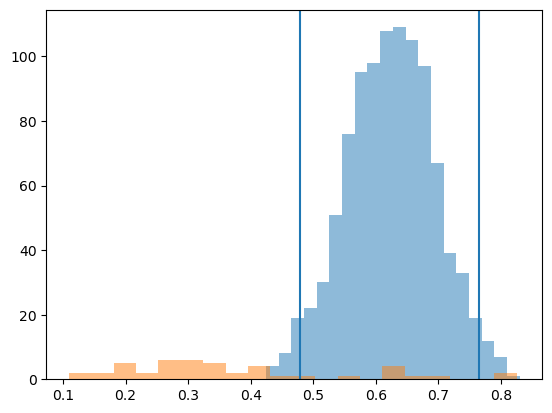

In [59]:
plt.hist(cross_channel_8_13, bins=20, alpha=0.5)
plt.hist(cross_schizo, bins=20, alpha=0.5)
plt.axvline(lower_bound)
plt.axvline(upper_bound)

In [56]:
bootstrap_samples = [
    np.random.choice(schizo_patients, size=5, replace=True)
    for _ in range(100)
]
cross_channel_8_13_schizo = [
    average_csd(sample)[8, 13]
    for sample in bootstrap_samples
]

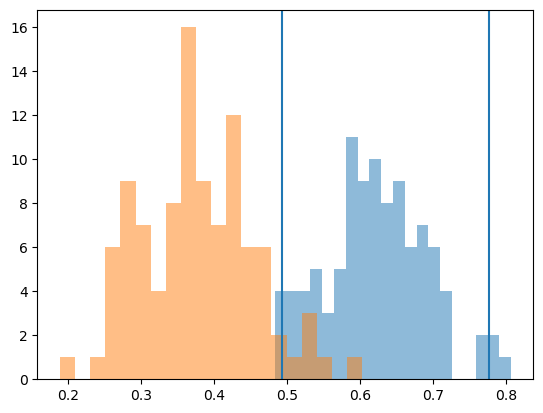

In [68]:
plt.hist(cross_channel_8_13, bins=20, alpha=0.5)
plt.hist(cross_channel_8_13_schizo, bins=20, alpha=0.5)
plt.axvline(lower_bound)
plt.axvline(upper_bound)